This notebook takes in a text file, works out the columns, timezone, and CRS, then outputs a standard geojson.

In [1]:
import uuid
import re, os
from pathlib import Path
from pprint import pprint
from tqdm import tqdm

import pytz
import arrow 

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd


plt.rcParams['figure.figsize'] = (15, 5) # bigger plots
plt.style.use('fivethirtyeight')
%matplotlib inline
%precision 4

'%.4f'

# what are the columns?

It seems the we have 29 columns?

The top left 47486 match inspections https://services1.arcgis.com/PuB3FWUAxkScvfQy/ArcGIS/rest/services/LPI/FeatureServer/0

The bottom right match repairs https://services1.arcgis.com/PuB3FWUAxkScvfQy/ArcGIS/rest/services/Leaks_Repaired_Last_24hrs/FeatureServer/0

The combined columns that I can work out are below, the unknown just have numbers.
 
There is an overlap from city to Y but this is not enougth to join the events. Time might be however.

We are interested in the leak repairs.

In [2]:
columns = [
 'OBJECTID',
 'INSPFLAG',
 'PRI',
 'PROB',
 'PROBDTTM',
 'SCHEDDTTM',
 'SERVNO',
 'MAPNO',
 'STARTDTTM',
 'PROBCODE',
 'PROBDESC',
 'CITY',
 'PREDIR',
 'STNAME',
 'STNO',
 'STSUB',
 'SUFFIX',
 'ZIP',
 'ADDRKEY',
 'FullStreetName',
 'X',
 'Y',
 '22', # CMPLKEY (Complementary key?, INT)?, SERVER (nah thats 47486-627096, Objectid (no too high)?? 1913-1496485. 
 'QTYCALLS', # 1-120 mostly one, shared by both. PRob QTYCALLS. Quantity of calls?
 'INITDTTM', # initial date time
 'WONO', # work order number?
 'LOC', # needed to look at more example to determine this
 'DESCRIPT',
 'COMPDTTM' # This matches COMPDTTM from https://services1.arcgis.com/PuB3FWUAxkScvfQy/ArcGIS/rest/services/Leaks_Repaired_Last_24hrs/FeatureServer/0
]

In [3]:
data_path = Path('../../data/leak_datasets/austin_leaks/PIR_Leaks2.txt').resolve()

In [4]:
# df = pd.read_csv(data_path, header=None ,names=columns, index_col=0)
df = pd.read_csv(data_path, header=None ,names=columns, index_col=0)
df

/tmp/ipykernel_62394/2435993741.py:2: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,24,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, header=None ,names=columns, index_col=0)


,INSPFLAG,PRI,PROB,PROBDTTM,SCHEDDTTM,SERVNO,MAPNO,STARTDTTM,PROBCODE,PROBDESC,...,FullStreetName,X,Y,22,QTYCALLS,INITDTTM,WONO,LOC,DESCRIPT,COMPDTTM
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,Y,1,SERLK,7/3/2015 19:26:00,7/3/2015 19:28:00,566188.0,465Y,7/3/2015 19:47:00,SERLK,LEAKING WATER SERVICE,...,11925 1/2 ALTERRA PKWY,3120697.53,10121089.21,NaN,1,NaN,NaN,NaN,NaN,NaN
2,Y,3,CCOLK,6/22/2007 12:06:00,6/22/2007 16:45:00,314762.0,615B,6/23/2007 3:41:00,CCOLK,LEAKING/CHECK CITY CUT OFF,...,1305 E 4TH ST,3118411.37,10068599.12,NaN,1,NaN,NaN,NaN,NaN,NaN
3,Y,3,MTRLK,6/14/2006 14:15:00,7/3/2006 16:21:00,280152.0,585Y,7/4/2006 14:24:00,MTRLK,LEAKING WATER METER,...,1400 E 4TH ST,3118802.75,10068659.00,NaN,2,NaN,NaN,NaN,NaN,NaN
4,Y,1,MTRLK,6/6/2011 17:02:00,6/6/2011 17:04:00,430378.0,585Y,6/6/2011 18:44:00,MTRLK,LEAKING WATER METER,...,1400 E 4TH ST,3118802.75,10068659.00,NaN,1,NaN,NaN,NaN,NaN,NaN
5,Y,3,MTRLK,3/3/2005 16:06:00,3/8/2005 8:28:00,235202.0,614R,3/23/2005 15:13:00,MTRLK,LEAKING WATER METER,...,2414 S 1ST ST,3109047.73,10061026.95,NaN,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1500 BRENTWOOD ST,3117857.50,10096352.00,1194725.0,1,2/7/2017 12:51:00,1813689.0,NaN,WATER METER LEAK,2/7/2017 15:19:00
70614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8500 KEARSARGE CV,3089442.50,10042473.00,405181.0,3,2/5/2017 12:32:00,1812801.0,NaN,WATER SERVICE LEAK,2/6/2017 16:30:00
70615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1223 WEST LYNN ST,3109307.25,10075302.00,1493994.0,1,1/24/2017 8:38:00,1809358.0,13TH ST.,WATER SERVICE LEAK,1/24/2017 22:45:00


# Transforming cols

In [5]:
# turn the american datestring (in austin timezone) into pandas utc datetime
def parse_dttm_b(s):
    if isinstance(s,str):
        return arrow.get(s,'M/D/YYYY H:mm:ss',tzinfo='US/Central').astimezone(pytz.utc).isoformat()
    else:
        return s

DTTM_cols = [col for col in df.columns if col.endswith('DTTM')]
for col in tqdm(['PROBDTTM', 'SCHEDDTTM', 'STARTDTTM', 'INITDTTM', 'COMPDTTM']):
    df[col]=pd.to_datetime(df[col].apply(parse_dttm_b),utc=True)
df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


,INSPFLAG,PRI,PROB,PROBDTTM,SCHEDDTTM,SERVNO,MAPNO,STARTDTTM,PROBCODE,PROBDESC,...,FullStreetName,X,Y,22,QTYCALLS,INITDTTM,WONO,LOC,DESCRIPT,COMPDTTM
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,Y,1,SERLK,2015-07-04 00:26:00+00:00,2015-07-04 00:28:00+00:00,566188.0,465Y,2015-07-04 00:47:00+00:00,SERLK,LEAKING WATER SERVICE,...,11925 1/2 ALTERRA PKWY,3120697.53,10121089.21,NaN,1,NaT,NaN,NaN,NaN,NaT
2,Y,3,CCOLK,2007-06-22 17:06:00+00:00,2007-06-22 21:45:00+00:00,314762.0,615B,2007-06-23 08:41:00+00:00,CCOLK,LEAKING/CHECK CITY CUT OFF,...,1305 E 4TH ST,3118411.37,10068599.12,NaN,1,NaT,NaN,NaN,NaN,NaT
3,Y,3,MTRLK,2006-06-14 19:15:00+00:00,2006-07-03 21:21:00+00:00,280152.0,585Y,2006-07-04 19:24:00+00:00,MTRLK,LEAKING WATER METER,...,1400 E 4TH ST,3118802.75,10068659.00,NaN,2,NaT,NaN,NaN,NaN,NaT
4,Y,1,MTRLK,2011-06-06 22:02:00+00:00,2011-06-06 22:04:00+00:00,430378.0,585Y,2011-06-06 23:44:00+00:00,MTRLK,LEAKING WATER METER,...,1400 E 4TH ST,3118802.75,10068659.00,NaN,1,NaT,NaN,NaN,NaN,NaT
5,Y,3,MTRLK,2005-03-03 22:06:00+00:00,2005-03-08 14:28:00+00:00,235202.0,614R,2005-03-23 21:13:00+00:00,MTRLK,LEAKING WATER METER,...,2414 S 1ST ST,3109047.73,10061026.95,NaN,1,NaT,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70613,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,...,1500 BRENTWOOD ST,3117857.50,10096352.00,1194725.0,1,2017-02-07 18:51:00+00:00,1813689.0,NaN,WATER METER LEAK,2017-02-07 21:19:00+00:00
70614,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,...,8500 KEARSARGE CV,3089442.50,10042473.00,405181.0,3,2017-02-05 18:32:00+00:00,1812801.0,NaN,WATER SERVICE LEAK,2017-02-06 22:30:00+00:00
70615,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,...,1223 WEST LYNN ST,3109307.25,10075302.00,1493994.0,1,2017-01-24 14:38:00+00:00,1809358.0,13TH ST.,WATER SERVICE LEAK,2017-01-25 04:45:00+00:00


In [14]:
# test
assert arrow.get(1474131660000/1000)==arrow.get(df.loc[69665].INITDTTM),'should be equal after conversion'
assert arrow.get(1483936920000/1000)==arrow.get(df.loc[70392].COMPDTTM),'should be equal after conversion'
assert arrow.get(1484258400000/1000)==arrow.get(df.loc[5811].SCHEDDTTM),'should be equal after conversion'
assert arrow.get(1484258160000/1000)==arrow.get(df.loc[5811].PROBDTTM),'should be equal after conversion'
assert arrow.get(1484262840000/1000)==arrow.get(df.loc[5811].STARTDTTM),'should be equal after conversion'

# assert arrow.get(LWOPR_69665['INITDTTM']/1000)==arrow.get(df.loc[69665].INITDTTM),'should be equal after conversion'
# assert arrow.get(LRL24h_70392['COMPDTTM']/1000)==arrow.get(df.loc[70392].COMPDTTM),'should be equal after conversion'
# assert arrow.get(LPI_5811['SCHEDDTTM']/1000)==arrow.get(df.loc[5811].SCHEDDTTM),'should be equal after conversion'
# assert arrow.get(LPI_5811['PROBDTTM']/1000)==arrow.get(df.loc[5811].PROBDTTM),'should be equal after conversion'
# assert arrow.get(LPI_5811['STARTDTTM']/1000)==arrow.get(df.loc[5811].STARTDTTM),'should be equal after conversion'

In [7]:
# TODO make sure there are no NaT?

## Save to CSV

In [6]:
(data_path.parent / 'derived' / 'austin_leaks_with_headers.csv').parent.mkdir(parents=True)

FileExistsError: [Errno 17] File exists: '/home/dmitrii/Documents/work/satellite_leak_detection/data/leak_datasets/austin_leaks/derived'

In [8]:
df.to_csv(data_path.parent / 'derived' / 'austin_leaks_with_headers.csv', date_format='iso')

## Converting CRS

Convert to the google maps CRS. 

It looks like the crs is pyproj.Proj(init='EPSG:6578') and it has to be multiplied by 1200.0/3937 first to convert to meters

In [9]:
import pyproj

from pyproj import Transformer

survey_foot_to_m=1

transformer = Transformer.from_crs('EPSG:6578', 'EPSG:3857')


# p0=pyproj.Proj('EPSG:6578') # NAD83(2011) / Texas Central (ftUS)
# p1=pyproj.Proj('EPSG:3857') #  WGS84 Web Mercator (Auxiliary Sphere) 

def convert_to_3857(X,Y):
    return transformer.transform(X*survey_foot_to_m, Y*survey_foot_to_m)

x,y=convert_to_3857(df.X.values, df.Y.values)
df['x']=x
df['y']=y
# df.drop(['X','Y'])


# test using data from thier webmap
x0,y0=convert_to_3857(3133157.5, 10085295.0)
assert (x0 - -10873914.4433)<1,'should work for test data'
assert (y0 - 3543050.4391)<1,'should work for test data'
df

,INSPFLAG,PRI,PROB,PROBDTTM,SCHEDDTTM,SERVNO,MAPNO,STARTDTTM,PROBCODE,PROBDESC,...,Y,22,QTYCALLS,INITDTTM,WONO,LOC,DESCRIPT,COMPDTTM,x,y
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,Y,1,SERLK,2015-07-04 00:26:00+00:00,2015-07-04 00:28:00+00:00,566188.0,465Y,2015-07-04 00:47:00+00:00,SERLK,LEAKING WATER SERVICE,...,10121089.21,NaN,1,NaT,NaN,NaN,NaN,NaT,-1.087801e+07,3.555848e+06
2,Y,3,CCOLK,2007-06-22 17:06:00+00:00,2007-06-22 21:45:00+00:00,314762.0,615B,2007-06-23 08:41:00+00:00,CCOLK,LEAKING/CHECK CITY CUT OFF,...,10068599.12,NaN,1,NaT,NaN,NaN,NaN,NaT,-1.087925e+07,3.537257e+06
3,Y,3,MTRLK,2006-06-14 19:15:00+00:00,2006-07-03 21:21:00+00:00,280152.0,585Y,2006-07-04 19:24:00+00:00,MTRLK,LEAKING WATER METER,...,10068659.00,NaN,2,NaT,NaN,NaN,NaN,NaT,-1.087911e+07,3.537275e+06
4,Y,1,MTRLK,2011-06-06 22:02:00+00:00,2011-06-06 22:04:00+00:00,430378.0,585Y,2011-06-06 23:44:00+00:00,MTRLK,LEAKING WATER METER,...,10068659.00,NaN,1,NaT,NaN,NaN,NaN,NaT,-1.087911e+07,3.537275e+06
5,Y,3,MTRLK,2005-03-03 22:06:00+00:00,2005-03-08 14:28:00+00:00,235202.0,614R,2005-03-23 21:13:00+00:00,MTRLK,LEAKING WATER METER,...,10061026.95,NaN,1,NaT,NaN,NaN,NaN,NaT,-1.088261e+07,3.534652e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70613,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,...,10096352.00,1194725.0,1,2017-02-07 18:51:00+00:00,1813689.0,NaN,WATER METER LEAK,2017-02-07 21:19:00+00:00,-1.087922e+07,3.547098e+06
70614,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,...,10042473.00,405181.0,3,2017-02-05 18:32:00+00:00,1812801.0,NaN,WATER SERVICE LEAK,2017-02-06 22:30:00+00:00,-1.088967e+07,3.528240e+06
70615,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,...,10075302.00,1493994.0,1,2017-01-24 14:38:00+00:00,1809358.0,13TH ST.,WATER SERVICE LEAK,2017-01-25 04:45:00+00:00,-1.088241e+07,3.539707e+06


In [21]:
df[["x", "y"]].applymap('{:.2f}'.format)

,x,y
OBJECTID,,
1,-10878011.08,3555847.64
2,-10879251.91,3537256.91
3,-10879113.45,3537274.88
4,-10879113.45,3537274.88
5,-10882614.41,3534651.73
...,...,...
70613,-10879218.14,3547097.55
70614,-10889671.58,3528240.09
70615,-10882406.47,3539706.92


## To geojson

In [10]:
# converting to geojson
from collections import OrderedDict
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[], "crs": {"type": "name", "properties": {"name": "EPSG:3857"}}}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':OrderedDict(),
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson



cols = df.columns.drop(['X','Y','x','y'])
geoj = df_to_geojson(df.copy(),properties=cols,lat='y',lon='x')
gdf = gpd.GeoDataFrame.from_features(geoj['features'], crs='epsg:3857')
gdf = gdf.to_crs(epsg=4326) # geojson only supports this by default
gdf

,geometry,INSPFLAG,PRI,PROB,PROBDTTM,SCHEDDTTM,SERVNO,MAPNO,STARTDTTM,PROBCODE,...,ZIP,ADDRKEY,FullStreetName,22,QTYCALLS,INITDTTM,WONO,LOC,DESCRIPT,COMPDTTM
0,POINT (-97.71884 30.40602),Y,1,SERLK,2015-07-04 00:26:00+00:00,2015-07-04 00:28:00+00:00,566188.0,465Y,2015-07-04 00:47:00+00:00,SERLK,...,78758-,3506121.0,11925 1/2 ALTERRA PKWY,NaN,1,NaT,NaN,NaN,NaN,NaT
1,POINT (-97.72998 30.26188),Y,3,CCOLK,2007-06-22 17:06:00+00:00,2007-06-22 21:45:00+00:00,314762.0,615B,2007-06-23 08:41:00+00:00,CCOLK,...,78702-,400994.0,1305 E 4TH ST,NaN,1,NaT,NaN,NaN,NaN,NaT
2,POINT (-97.72874 30.26202),Y,3,MTRLK,2006-06-14 19:15:00+00:00,2006-07-03 21:21:00+00:00,280152.0,585Y,2006-07-04 19:24:00+00:00,MTRLK,...,78702-,362708.0,1400 E 4TH ST,NaN,2,NaT,NaN,NaN,NaN,NaT
3,POINT (-97.72874 30.26202),Y,1,MTRLK,2011-06-06 22:02:00+00:00,2011-06-06 22:04:00+00:00,430378.0,585Y,2011-06-06 23:44:00+00:00,MTRLK,...,78702-,362708.0,1400 E 4TH ST,NaN,1,NaT,NaN,NaN,NaN,NaT
4,POINT (-97.76019 30.24167),Y,3,MTRLK,2005-03-03 22:06:00+00:00,2005-03-08 14:28:00+00:00,235202.0,614R,2005-03-23 21:13:00+00:00,MTRLK,...,78704-,299714.0,2414 S 1ST ST,NaN,1,NaT,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70612,POINT (-97.72968 30.33821),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78757-,355628.0,1500 BRENTWOOD ST,1194725.0,1,2017-02-07 18:51:00+00:00,1813689.0,NaN,WATER METER LEAK,2017-02-07 21:19:00+00:00
70613,POINT (-97.82358 30.19190),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78749-,534489.0,8500 KEARSARGE CV,405181.0,3,2017-02-05 18:32:00+00:00,1812801.0,NaN,WATER SERVICE LEAK,2017-02-06 22:30:00+00:00
70614,POINT (-97.75832 30.28089),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78703-,388862.0,1223 WEST LYNN ST,1493994.0,1,2017-01-24 14:38:00+00:00,1809358.0,13TH ST.,WATER SERVICE LEAK,2017-01-25 04:45:00+00:00
70615,POINT (-97.74702 30.17176),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78744-,292227.0,7220 FIREFLY DR,392294.0,1,2017-01-24 20:54:00+00:00,1809798.0,NaN,WATER SERVICE LEAK,2017-01-25 01:40:00+00:00


In [11]:
# the geopandas to_json can't handle dates, so lets manually convert them to isoformat
def to_isoformat(t):
    try:
        return t.isoformat()
    except Exception as e:
        return None

for col in tqdm(gdf.columns):
    if col.endswith('DTTM'):
        gdf[col]=gdf[col].apply(to_isoformat) #.astype(str)
gdf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 39.28it/s]


,geometry,INSPFLAG,PRI,PROB,PROBDTTM,SCHEDDTTM,SERVNO,MAPNO,STARTDTTM,PROBCODE,...,ZIP,ADDRKEY,FullStreetName,22,QTYCALLS,INITDTTM,WONO,LOC,DESCRIPT,COMPDTTM
0,POINT (-97.71884 30.40602),Y,1,SERLK,2015-07-04T00:26:00+00:00,2015-07-04T00:28:00+00:00,566188.0,465Y,2015-07-04T00:47:00+00:00,SERLK,...,78758-,3506121.0,11925 1/2 ALTERRA PKWY,NaN,1,NaT,NaN,NaN,NaN,NaT
1,POINT (-97.72998 30.26188),Y,3,CCOLK,2007-06-22T17:06:00+00:00,2007-06-22T21:45:00+00:00,314762.0,615B,2007-06-23T08:41:00+00:00,CCOLK,...,78702-,400994.0,1305 E 4TH ST,NaN,1,NaT,NaN,NaN,NaN,NaT
2,POINT (-97.72874 30.26202),Y,3,MTRLK,2006-06-14T19:15:00+00:00,2006-07-03T21:21:00+00:00,280152.0,585Y,2006-07-04T19:24:00+00:00,MTRLK,...,78702-,362708.0,1400 E 4TH ST,NaN,2,NaT,NaN,NaN,NaN,NaT
3,POINT (-97.72874 30.26202),Y,1,MTRLK,2011-06-06T22:02:00+00:00,2011-06-06T22:04:00+00:00,430378.0,585Y,2011-06-06T23:44:00+00:00,MTRLK,...,78702-,362708.0,1400 E 4TH ST,NaN,1,NaT,NaN,NaN,NaN,NaT
4,POINT (-97.76019 30.24167),Y,3,MTRLK,2005-03-03T22:06:00+00:00,2005-03-08T14:28:00+00:00,235202.0,614R,2005-03-23T21:13:00+00:00,MTRLK,...,78704-,299714.0,2414 S 1ST ST,NaN,1,NaT,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70612,POINT (-97.72968 30.33821),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78757-,355628.0,1500 BRENTWOOD ST,1194725.0,1,2017-02-07T18:51:00+00:00,1813689.0,NaN,WATER METER LEAK,2017-02-07T21:19:00+00:00
70613,POINT (-97.82358 30.19190),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78749-,534489.0,8500 KEARSARGE CV,405181.0,3,2017-02-05T18:32:00+00:00,1812801.0,NaN,WATER SERVICE LEAK,2017-02-06T22:30:00+00:00
70614,POINT (-97.75832 30.28089),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78703-,388862.0,1223 WEST LYNN ST,1493994.0,1,2017-01-24T14:38:00+00:00,1809358.0,13TH ST.,WATER SERVICE LEAK,2017-01-25T04:45:00+00:00
70615,POINT (-97.74702 30.17176),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,78744-,292227.0,7220 FIREFLY DR,392294.0,1,2017-01-24T20:54:00+00:00,1809798.0,NaN,WATER SERVICE LEAK,2017-01-25T01:40:00+00:00


In [12]:
# Add main columns
gdf['OBJECTID']=gdf.index # want to keep this so add as a property
gdf['REPO_Date']=gdf['COMPDTTM']
gdf['leak_id']=gdf.OBJECTID.apply(lambda x:'ATX-%s'%x)
gdf

,geometry,INSPFLAG,PRI,PROB,PROBDTTM,SCHEDDTTM,SERVNO,MAPNO,STARTDTTM,PROBCODE,...,22,QTYCALLS,INITDTTM,WONO,LOC,DESCRIPT,COMPDTTM,OBJECTID,REPO_Date,leak_id
0,POINT (-97.71884 30.40602),Y,1,SERLK,2015-07-04T00:26:00+00:00,2015-07-04T00:28:00+00:00,566188.0,465Y,2015-07-04T00:47:00+00:00,SERLK,...,NaN,1,NaT,NaN,NaN,NaN,NaT,0,NaT,ATX-0
1,POINT (-97.72998 30.26188),Y,3,CCOLK,2007-06-22T17:06:00+00:00,2007-06-22T21:45:00+00:00,314762.0,615B,2007-06-23T08:41:00+00:00,CCOLK,...,NaN,1,NaT,NaN,NaN,NaN,NaT,1,NaT,ATX-1
2,POINT (-97.72874 30.26202),Y,3,MTRLK,2006-06-14T19:15:00+00:00,2006-07-03T21:21:00+00:00,280152.0,585Y,2006-07-04T19:24:00+00:00,MTRLK,...,NaN,2,NaT,NaN,NaN,NaN,NaT,2,NaT,ATX-2
3,POINT (-97.72874 30.26202),Y,1,MTRLK,2011-06-06T22:02:00+00:00,2011-06-06T22:04:00+00:00,430378.0,585Y,2011-06-06T23:44:00+00:00,MTRLK,...,NaN,1,NaT,NaN,NaN,NaN,NaT,3,NaT,ATX-3
4,POINT (-97.76019 30.24167),Y,3,MTRLK,2005-03-03T22:06:00+00:00,2005-03-08T14:28:00+00:00,235202.0,614R,2005-03-23T21:13:00+00:00,MTRLK,...,NaN,1,NaT,NaN,NaN,NaN,NaT,4,NaT,ATX-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70612,POINT (-97.72968 30.33821),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,1194725.0,1,2017-02-07T18:51:00+00:00,1813689.0,NaN,WATER METER LEAK,2017-02-07T21:19:00+00:00,70612,2017-02-07T21:19:00+00:00,ATX-70612
70613,POINT (-97.82358 30.19190),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,405181.0,3,2017-02-05T18:32:00+00:00,1812801.0,NaN,WATER SERVICE LEAK,2017-02-06T22:30:00+00:00,70613,2017-02-06T22:30:00+00:00,ATX-70613
70614,POINT (-97.75832 30.28089),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,1493994.0,1,2017-01-24T14:38:00+00:00,1809358.0,13TH ST.,WATER SERVICE LEAK,2017-01-25T04:45:00+00:00,70614,2017-01-25T04:45:00+00:00,ATX-70614
70615,POINT (-97.74702 30.17176),NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,...,392294.0,1,2017-01-24T20:54:00+00:00,1809798.0,NaN,WATER SERVICE LEAK,2017-01-25T01:40:00+00:00,70615,2017-01-25T01:40:00+00:00,ATX-70615


In [13]:
# export all
gdf.REPO_Date = gdf.COMPDTTM
geojson = gdf.to_json()
geojson_file1 = data_path.parent / 'derived' / 'austin_leaks.geojson'
geojson_file1.parent.mkdir(parents=True,exist_ok=True)
open(geojson_file1,'w').write(geojson)
geojson_file1

PosixPath('/home/dmitrii/Documents/work/satellite_leak_detection/data/leak_datasets/austin_leaks/derived/austin_leaks.geojson')

In [14]:
# split into inspections vs repairs
columns_inspections = ['leak_id','REPO_Date','ADDRKEY', 'CITY', 'FullStreetName', 'INSPFLAG', 'MAPNO', 'OBJECTID',
       'PREDIR', 'PRI', 'PROB', 'PROBCODE', 'PROBDESC', 'PROBDTTM', 'QTYCALLS',
       'SCHEDDTTM', 'SERVNO', 'STARTDTTM', 'STNAME', 'STNO', 'STSUB', 'SUFFIX',
       'ZIP', 'geometry']
columns_repairs = ['leak_id','REPO_Date','22', 'ADDRKEY', 'CITY', 'COMPDTTM', 'DESCRIPT', 'FullStreetName',
       'INITDTTM', 'LOC', 'OBJECTID', 'PREDIR', 'QTYCALLS', 'STNAME', 'STNO',
       'STSUB', 'SUFFIX', 'WONO', 'ZIP', 'geometry']

# gdf_inspections=gdf[pd.isnull(gdf.COMPDTTM)][columns_inspections]
# gdf_repairs=gdf[pd.isnull(gdf.COMPDTTM)==False][columns_repairs]
gdf_inspections=gdf['NaT'==gdf.COMPDTTM][columns_inspections]
gdf_repairs=gdf[('NaT'==gdf.COMPDTTM)==False][columns_repairs]


# export
geojson = gdf_inspections.to_json()
geojson_file_inspections = data_path.parent / 'derived' / 'austin_leaks-inspections.geojson'
open(geojson_file_inspections,'w').write(geojson)
print(geojson_file_inspections)

geojson = gdf_repairs.to_json()
geojson_file_repairs = data_path.parent / 'derived' / 'austin_leaks-repairs.geojson'
open(geojson_file_repairs,'w').write(geojson)
geojson_file_repairs

/home/dmitrii/Documents/work/satellite_leak_detection/data/leak_datasets/austin_leaks/derived/austin_leaks-inspections.geojson


PosixPath('/home/dmitrii/Documents/work/satellite_leak_detection/data/leak_datasets/austin_leaks/derived/austin_leaks-repairs.geojson')

In [15]:
gdf_repairs['COMPDTTM']

47486    2009-08-24T19:56:00+00:00
47487    2009-08-24T20:00:00+00:00
47488    2009-08-22T06:05:00+00:00
47489    2008-12-11T15:47:00+00:00
47490    2008-12-12T03:09:00+00:00
                   ...            
70612    2017-02-07T21:19:00+00:00
70613    2017-02-06T22:30:00+00:00
70614    2017-01-25T04:45:00+00:00
70615    2017-01-25T01:40:00+00:00
70616    2017-02-09T03:53:00+00:00
Name: COMPDTTM, Length: 23131, dtype: object

In [19]:
# small version of leaks
columns_whitelist = [
#  'INSPFLAG', # only 'Y' or NaN
#  'PRI',
#  'PROB',
#  'PROBDTTM',
 'SCHEDDTTM',
#  'SERVNO',
#  'MAPNO',
 'STARTDTTM',
 'PROBCODE',
 'PROBDESC',
#  'CITY',
#  'PREDIR',
#  'STNAME',
#  'STNO',
#  'STSUB',
#  'SUFFIX',
#  'ZIP',
#  'ADDRKEY',
 'FullStreetName',
#  'X',
#  'Y',
#  '22',
#  'QTYCALLS',
#  'INITDTTM',
#  'WONO',
 'LOC',
 'DESCRIPT',
 'COMPDTTM',
 'geometry'
]
geojson = gdf[columns_whitelist].to_json()
geojson_file = data_path.parent / 'derived'/ 'austin_leaks-small.geojson'
geojson_file.parent.mkdir(parents=True, exist_ok=True)
open(geojson_file,'w').write(geojson)
geojson_file

PosixPath('/home/dmitrii/Documents/work/satellite_leak_detection/data/leak_datasets/austin_leaks/derived/austin_leaks-small.geojson')

In [20]:
# small version of repairs
columns_whitelist = [
#  'INSPFLAG', # only 'Y' or NaN
#  'PRI',
#  'PROB',
#  'PROBDTTM',
#  'SCHEDDTTM',
#  'SERVNO',
#  'MAPNO',
#  'STARTDTTM',
#  'PROBCODE',
#  'PROBDESC',
#  'CITY',
#  'PREDIR',
#  'STNAME',
#  'STNO',
#  'STSUB',
#  'SUFFIX',
#  'ZIP',
#  'ADDRKEY',
 'FullStreetName',
#  'X',
#  'Y',
#  '22',
#  'QTYCALLS',
#  'INITDTTM',
#  'WONO',
 'LOC',
 'DESCRIPT',
 'COMPDTTM',
 'geometry'
]
geojson = gdf_repairs[columns_whitelist].to_json()
geojson_file = data_path.parent / 'derived' / 'austin_leaks-repairs-small.geojson'
geojson_file.parent.mkdir(parents=True, exist_ok=True)
open(geojson_file,'w').write(geojson)
geojson_file

PosixPath('/home/dmitrii/Documents/work/satellite_leak_detection/data/leak_datasets/austin_leaks/derived/austin_leaks-repairs-small.geojson')

In [21]:
# test
gdf2=gpd.read_file(geojson_file_repairs)
gdf2

,id,leak_id,REPO_Date,22,ADDRKEY,CITY,COMPDTTM,DESCRIPT,FullStreetName,INITDTTM,...,OBJECTID,PREDIR,QTYCALLS,STNAME,STNO,STSUB,SUFFIX,WONO,ZIP,geometry
0,47486,ATX-47486,2009-08-24 19:56:00+00:00,195724.0,918296.0,AUSTIN,2009-08-24 19:56:00+00:00,WATER SERVICE LEAK,4703 MESA OAKS CIR,2009-08-23 00:20:00+00:00,...,47486,,1,MESA OAKS,4703,,CIR,580930.0,78735-,POINT (-97.82460 30.24299)
1,47487,ATX-47487,2009-08-24 20:00:00+00:00,353552.0,918014.0,AUSTIN,2009-08-24 20:00:00+00:00,WATER SERVICE LEAK,4842 CANYONBEND CIR,2009-08-23 00:50:00+00:00,...,47487,,2,CANYONBEND,4842,,CIR,580932.0,78735-,POINT (-97.82675 30.24220)
2,47488,ATX-47488,2009-08-22 06:05:00+00:00,959696.0,951692.0,AUSTIN,2009-08-22 06:05:00+00:00,WATER METER LEAK,9200 SAN JUAN PASS,2009-08-22 03:32:00+00:00,...,47488,,2,SAN JUAN,9200,,PASS,580915.0,78737-,POINT (-97.90544 30.21939)
3,47489,ATX-47489,2008-12-11 15:47:00+00:00,669430.0,201806.0,AUSTIN,2008-12-11 15:47:00+00:00,WATER METER LEAK,1503 WEST AVE,2008-12-08 16:54:00+00:00,...,47489,,2,WEST,1503,,AVE,444845.0,78701-,POINT (-97.74689 30.27942)
4,47490,ATX-47490,2008-12-12 03:09:00+00:00,979049.0,799934.0,AUSTIN,2008-12-12 03:09:00+00:00,WATER MAIN LEAK,4506 OAKMONT BLVD,2008-12-05 21:58:00+00:00,...,47490,,1,OAKMONT,4506,,BLVD,444473.0,78731-,POINT (-97.75149 30.32082)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23126,70612,ATX-70612,2017-02-07 21:19:00+00:00,1194725.0,355628.0,AUSTIN,2017-02-07 21:19:00+00:00,WATER METER LEAK,1500 BRENTWOOD ST,2017-02-07 18:51:00+00:00,...,70612,,1,BRENTWOOD,1500,,ST,1813689.0,78757-,POINT (-97.72968 30.33821)
23127,70613,ATX-70613,2017-02-06 22:30:00+00:00,405181.0,534489.0,AUSTIN,2017-02-06 22:30:00+00:00,WATER SERVICE LEAK,8500 KEARSARGE CV,2017-02-05 18:32:00+00:00,...,70613,,3,KEARSARGE,8500,,CV,1812801.0,78749-,POINT (-97.82358 30.19190)
23128,70614,ATX-70614,2017-01-25 04:45:00+00:00,1493994.0,388862.0,AUSTIN,2017-01-25 04:45:00+00:00,WATER SERVICE LEAK,1223 WEST LYNN ST,2017-01-24 14:38:00+00:00,...,70614,,1,WEST LYNN,1223,,ST,1809358.0,78703-,POINT (-97.75832 30.28089)
23129,70615,ATX-70615,2017-01-25 01:40:00+00:00,392294.0,292227.0,AUSTIN,2017-01-25 01:40:00+00:00,WATER SERVICE LEAK,7220 FIREFLY DR,2017-01-24 20:54:00+00:00,...,70615,,1,FIREFLY,7220,,DR,1809798.0,78744-,POINT (-97.74702 30.17176)


# Working out columns

I have some labeled data I scraped from thier server, so I can use it to work out matching columns (and what db they come from).

In [ ]:
columns=range(29)
df1 = pd.read_csv(data_path, header=None ,nrows=47486, names=columns, index_col=0)
df1.T
df2 = pd.read_csv(data_path, header=None ,skiprows=47486, names=columns, index_col=0)
df2

In [11]:
# how to parse file times to to utc time
t=arrow.get('1/12/2017 15:56:00','D+/M+/YYYY HH:mm:ss',tzinfo='US/Central').astimezone(pytz.utc)
t.isoformat()

'2017-12-01T21:56:00+00:00'

In [136]:
# compare this LWOPR
LWOPR_69665 = json.loads('''{
            "Editor": "InterAGO",
            "CreationDate": 1474259828703,
            "PROB": "WSLK",
            "STNO": " 11500",
            "QTYCALLS": "2",
            "STARTFLAG": "N",
            "CITY": "DEL VALLE",
            "SUFFIX": "ST",
            "SCHEDDTTM": null,
            "LOC": null,
            "ADDRKEY": 201879,
            "PROBDTTM": 1474124400000,
            "STSUB": " ",
            "DESCRIPT": "WATER SERVICE LEAK",
            "ZIP": "78617-    ",
            "COMPKEY": null,
            "Creator": "InterAGO",
            "EditDate": 1474259828703,
            "STNAME": "GEMMER",
            "INITDTTM": 1474131660000,
            "CMPLKEY": 612058,
            "PREDIR": " ",
            "WONO": "  1779246",
            "STARTDTTM": null,
            "COMPFLAG": "N",
            "OBJECTID": 808366,
            "X": 3144909.75,
            "FullStreetName": "11500 GEMMER ST",
            "MAPNO": "677X",
            "Y": 10031944
        }''')
LWOPR_69665
df2[df2.index==69665].T

# convert the times
# CreationDate 1474259828703 <Arrow [2016-09-18T23:37:08.703000-05:00]>
# PROBDTTM <Arrow [2016-09-17T10:00:00-05:00]>
# EditDate <Arrow [2016-09-18T23:37:08.703000-05:00]>
# INITDTTM <Arrow [2016-09-17T12:01:00-05:00]>
# arrow.get(arrow.get(1474131660000/1000).astimezone(pytz.timezone('Etc/GMT+5')))

OBJECTID,69665
INSPFLAG,NaN
PRI,NaN
PROB,NaN
PROBDTTM,NaN
SCHEDDTTM,NaN
SERVNO,NaN
MAPNO,NaN
STARTDTTM,NaN
PROBCODE,NaN
PROBDESC,NaN


In [137]:
import json
# here's some lablled data from the server, it matche object id 5811
LPI_5811=json.loads('''{
            "SUFFIX": "DR",
            "EditDate": 1484668313471,
            "PROBDTTM": 1484258160000,
            "Editor": "InterAGO",
            "COMPKEY": null,
            "STARTDTTM": 1484262840000,
            "ZIP": "78745-    ",
            "ADDRKEY": 151694,
            "PROBDESC": "WATER MAIN LEAK",
            "PRI": "1",
            "PROBCODE": "WMNLK",
            "SERVNO": 623398,
            "FullStreetName": "5901 CHERRY CREEK DR",
            "PREDIR": " ",
            "OBJECTID": 393223,
            "CITY": "AUSTIN",
            "STNAME": "CHERRY CREEK",
            "QTYCALLS": "1",
            "STNO": "  5901",
            "Y": 10052310,
            "X": 3093377.5,
            "SCHEDDTTM": 1484258400000,
            "INSPDTTM": null,
            "Creator": "InterAGO",
            "MAPNO": "643G",
            "INSPFLAG": "N",
            "CreationDate": 1484668313471,
            "STSUB": " ",
            "PROB": "WMNLK"
        }''')
df1[df1.index==5811].T

OBJECTID,5811
INSPFLAG,Y
PRI,1
PROB,WMNLK
PROBDTTM,1/12/2017 15:56:00
SCHEDDTTM,1/12/2017 16:00:00
SERVNO,623398
MAPNO,643G
STARTDTTM,1/12/2017 17:14:00
PROBCODE,WMNLK
PROBDESC,WATER MAIN LEAK


It all matches we are just missing some derived columns (editor, creationdate, creator). INSPDTTM is filled in as a flag not a date, it seems like it should be inspection datetime but perhaps it's used as something else.

In [14]:
df1[df1.FullStreetName=='2550 S IH 35 SVRD SB']

,INSPFLAG,PRI,PROB,PROBDTTM,SCHEDDTTM,SERVNO,MAPNO,STARTDTTM,PROBCODE,PROBDESC,...,FullStreetName,X,Y,22,QTYCALLS,INITDTTM,WONO,LOC,DESCRIPT,COMPDTTM
OBJECTID,,,,,,,,,,,,,,,,,,,,,
31782,Y,1,MTRLK,5/7/2008 10:40:00,5/7/2008 10:44:00,339071,615W,5/7/2008 13:10:00,MTRLK,LEAKING WATER METER,...,2550 S IH 35 SVRD SB,3114324.01,10057239.4,NaN,1,NaN,NaN,NaN,NaN,NaN
31783,Y,1,SERLK,7/19/2016 18:11:00,7/19/2016 18:12:00,606278,615W,7/19/2016 19:06:00,SERLK,LEAKING WATER SERVICE,...,2550 S IH 35 SVRD SB,3114324.01,10057239.4,NaN,2,NaN,NaN,NaN,NaN,NaN


In [15]:
# # is it LRL24? no
# df2[df2[19]=='6100 TURTLE DOVE DR']
# # is it LWOPR yes, and the times match
# df2[df2[19]=='2550 S IH 35 SVRD SB']


s='''{
            "Editor": "InterAGO",
            "CreationDate": 1474259828703,
            "PROB": "WSLK",
            "STNO": "  2550",
            "QTYCALLS": "1",
            "STARTFLAG": "N",
            "CITY": "AUSTIN",
            "SUFFIX": "SVRD",
            "SCHEDDTTM": 1474036620000,
            "LOC": null,
            "ADDRKEY": 120610,
            "PROBDTTM": 1474032840000,
            "STSUB": " ",
            "DESCRIPT": "WATER SERVICE LEAK",
            "ZIP": "78704-    ",
            "COMPKEY": null,
            "Creator": "InterAGO",
            "EditDate": 1474259828703,
            "STNAME": "IH 35",
            "INITDTTM": 1474036620000,
            "CMPLKEY": 611961,
            "PREDIR": "S",
            "WONO": "  1779055",
            "STARTDTTM": null,
            "COMPFLAG": "N",
            "OBJECTID": 808365,
            "X": 3114324.01,
            "FullStreetName": "2550 S IH 35 SVRD SB",
            "MAPNO": "615W",
            "Y": 10057239.4
        }'''
LWOPR_69482 = json.loads(s)
LWOPR_69482
df2[df2.index==69482].T

OBJECTID,69482
INSPFLAG,NaN
PRI,NaN
PROB,NaN
PROBDTTM,NaN
SCHEDDTTM,NaN
SERVNO,NaN
MAPNO,NaN
STARTDTTM,NaN
PROBCODE,NaN
PROBDESC,NaN


In [16]:
LRL24h_70392=json.loads('''{
            "LOC": null,
            "SUFFIX": "AVE",
            "EditDate": 1483977171052,
            "PROBDTTM": null,
            "Editor": "InterAGO",
            "DescriptionPROB": null,
            "STARTDTTM": null,
            "ZIP": "78759-    ",
            "WO_SR": null,
            "ADDRKEY": 251075,
            "PROBDESC": null,
            "DESCRIPT": "WATER SERVICE LEAK",
            "SERVNO": null,
            "FullStreetName": "3921 STECK AVE",
            "WONO": "  1802421",
            "PREDIR": " ",
            "OBJECTID": 1146678,
            "CITY": "AUSTIN",
            "STNAME": "STECK",
            "QTYCALLS": "3",
            "STNO": "  3921",
            "EndDTTM": null,
            "Y": 10108685,
            "X": 3110431.5,
            "SCHEDDTTM": null,
            "INSPDTTM": 1483890420000,
            "Creator": "InterAGO",
            "COMPDTTM": 1483936920000,
            "MAPNO": null,
            "INITDTTM": 1483889280000,
            "CreationDate": 1483977171052,
            "STSUB": " "
        }''')
df[df.ADDRKEY==251075].T
# 1483936920000 => <Arrow [2017-01-08T23:42:00-05:00]>

OBJECTID,70392
INSPFLAG,NaN
PRI,NaN
PROB,NaN
PROBDTTM,NaN
SCHEDDTTM,NaN
SERVNO,NaN
MAPNO,NaN
STARTDTTM,NaN
PROBCODE,NaN
PROBDESC,NaN


# Analysing times

count                      47444
mean      1 days 15:52:42.681898
std      26 days 00:56:38.563898
min         -2122 days +21:09:00
25%              0 days 00:03:00
50%              0 days 00:09:00
75%              0 days 01:33:00
max           3054 days 09:23:00
dtype: object

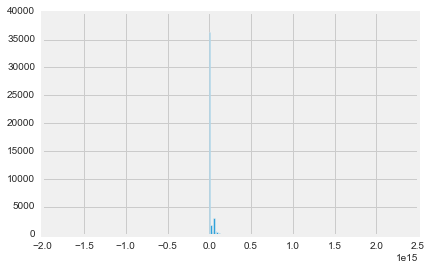

In [332]:
# difference between problem time and scheduled time in days
t=(df.SCHEDDTTM-df.PROBDTTM).dropna()

# remove outliers then plot
t2=t[np.abs(t.astype(int))<(26*864e11)]
t2.astype(int).hist(bins=200)

t.describe()


count                      47444
mean      0 days 19:56:44.951606
std      17 days 20:32:48.486246
min           -49 days +02:43:00
25%              0 days 00:29:00
50%              0 days 00:56:00
75%              0 days 03:20:00
max           2121 days 04:11:00
dtype: object

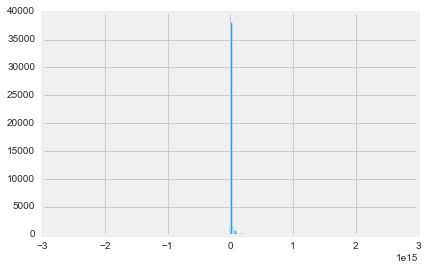

In [336]:
# difference between problem time and scheduled time in days
t=(df.STARTDTTM-df.SCHEDDTTM).dropna()

# remove outliers then plot
t2=t[np.abs(t.astype(int))<(26*864e11)]
t2.astype(int).hist(bins=200)

t.describe()

count                      47444
mean      1 days 15:52:42.681898
std      26 days 00:56:38.563898
min         -2122 days +21:09:00
25%              0 days 00:03:00
50%              0 days 00:09:00
75%              0 days 01:33:00
max           3054 days 09:23:00
dtype: object

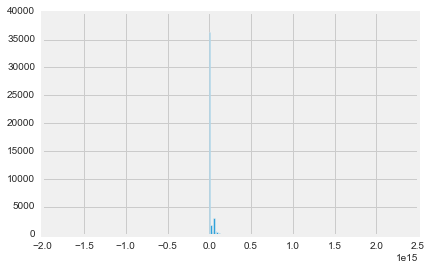

In [333]:
t=(df.SCHEDDTTM-df.PROBDTTM).dropna()
# remove outliers then plot
t2=t[np.abs(t.astype(int))<(26*864e11)]
t2.astype(int).hist(bins=200)

t.describe()

count                      23131
mean      4 days 08:26:02.819592
std      25 days 10:48:00.505569
min              0 days 00:00:00
25%              0 days 06:42:00
50%              0 days 14:36:00
75%              2 days 07:54:00
max           1065 days 05:42:00
dtype: object

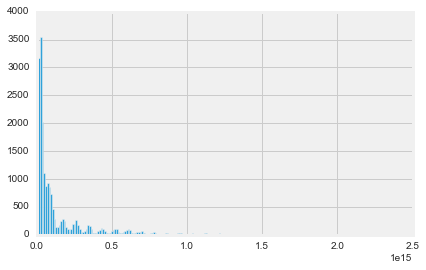

In [334]:
# difference between initial time and completed time in days
t=(df.COMPDTTM-df.INITDTTM).dropna()

# remove outliers then plot
t2=t[np.abs(t.astype(int))<(26*864e11)]
t2.astype(int).hist(bins=200)

t.describe()